In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
%cd /opt/notebooks/DeepMicroscopy
!rm -rf data
!unzip download

/opt/notebooks/DeepMicroscopy
Archive:  download
   creating: data/
 extracting: data/1589316952113.jpg  
 extracting: data/1589317363169.jpg  
 extracting: data/1589317369567.jpg  
 extracting: data/1589317376309.jpg  
 extracting: data/1590354443092.jpg  
 extracting: data/project.json       


In [4]:
#!rm -rf /content/models
#%cd /content
#!git clone --quiet https://github.com/tensorflow/models.git

[Errno 2] No such file or directory: '/content'
/opt/notebooks/Salt
/bin/sh: 1: git: not found


In [5]:
#%cd /content

!export DEBIAN_FRONTEND=noninteractive && apt update && apt install -qq protobuf-compiler python-pil python-lxml python-tk -y

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools pandas sklearn

#%cd /content/models/research
%cd /opt/notebooks/DeepMicroscopy
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] = ':/opt/notebooks/DeepMicroscopy/:/opt/notebooks/DeepMicroscopy/slim/'
#os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

Get:1 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  InRelease
Ign:1 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  InRelease
Get:2 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  Release [574 B]
Get:2 file:/var/nvinfer-runtime-trt-repo-5.0.2-ga-cuda10.0  Release [574 B]    
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease                    
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Ign:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fe

In [6]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf
import sys

sys.path.append("/opt/notebooks/DeepMicroscopy/")

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

import json
import sklearn
from sklearn.model_selection import train_test_split

from google.protobuf import text_format
from object_detection.protos import string_int_label_map_pb2
from object_detection.utils import label_map_util

class Via:

  def __init__(self,via_project):
    with open(via_project,'r') as f:
      self.via=json.loads(f.read())
      self.metadata=self.via['_via_img_metadata']
      self.path = os.path.dirname(via_project)

  def prepare(self):
    class_names = self._prepare_class_names()
    data_train, data_test = train_test_split(list(self.metadata.values()), test_size=0.3)
    label_map = self._prepare_label_map(class_names)
    self._prepare_tfdata(label_map,data_train,f'{self.path}/train.record')
    self._prepare_tfdata(label_map,data_test,f'{self.path}/test.record')

  def _prepare_tfdata(self, label_map, input_data, output_path):
      data=[]

      for v in input_data:
        for region in v['regions']:
          region_attributes=region['region_attributes']
          class_attribute=region_attributes['class']
          shape_attributes=region['shape_attributes']
          xmin = int(shape_attributes['x'])
          ymin = int(shape_attributes['y'])
          xmax = xmin+int(shape_attributes['width'])
          ymax = ymin+int(shape_attributes['height'])
          data.append([v['filename'],'1600','1200',class_attribute,xmin,ymin,xmax,ymax])

      df = pd.DataFrame(data,columns=['filename', 'width','height','class','xmin','ymin','xmax','ymax'])

      with tf.python_io.TFRecordWriter(output_path) as writer:
        grouped = self.__split(df, "filename")
        for group in grouped:
          tf_example = self.__create_tf_example(group, self.path, label_map)
          writer.write(tf_example.SerializeToString())
        writer.close()

  def _prepare_class_names(self):
    classes_names=[]

    for k,v in self.metadata.items():
      for region in v['regions']:
        region_attributes=region['region_attributes']
        class_attribute=region_attributes['class']
        classes_names.append(class_attribute)

    return list(set(classes_names))

  def _prepare_label_map(self, classes_names):
    pbtxt_content = ""
    label_map = {}
    for i, class_name in enumerate(classes_names):
      pbtxt_content = (pbtxt_content+"item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(i + 1, class_name))
      label_map[class_name] = i + 1

    pbtxt_content = pbtxt_content.strip()

    with open(f'{self.path}/label_map.pbtxt','w') as f:
      f.write(pbtxt_content)

    return label_map

  def __split(self, df, group):
      data = namedtuple("data", ["filename", "object"])
      gb = df.groupby(group)
      return [
          data(filename, gb.get_group(x))
          for filename, x in zip(gb.groups.keys(), gb.groups)
      ]

  def __create_tf_example(self, group, path, label_map):
      with tf.gfile.GFile(os.path.join(path, "{}".format(group.filename)), "rb") as fid:
          encoded_jpg = fid.read()
      encoded_jpg_io = io.BytesIO(encoded_jpg)
      image = Image.open(encoded_jpg_io)
      width, height = image.size

      filename = group.filename.encode("utf8")
      image_format = b"jpg"
      # check if the image format is matching with your images.
      xmins = []
      xmaxs = []
      ymins = []
      ymaxs = []
      classes_text = []
      classes = []

      for index, row in group.object.iterrows():
          xmins.append(row["xmin"] / width)
          xmaxs.append(row["xmax"] / width)
          ymins.append(row["ymin"] / height)
          ymaxs.append(row["ymax"] / height)
          classes_text.append(row["class"].encode("utf8"))
          class_index = label_map.get(row["class"])
          assert (
              class_index is not None
          ), "class label: `{}` not found in label_map: {}".format(
              row["class"], label_map
          )
          classes.append(class_index)

      tf_example = tf.train.Example(
          features=tf.train.Features(
              feature={
                  "image/height": dataset_util.int64_feature(height),
                  "image/width": dataset_util.int64_feature(width),
                  "image/filename": dataset_util.bytes_feature(filename),
                  "image/source_id": dataset_util.bytes_feature(filename),
                  "image/encoded": dataset_util.bytes_feature(encoded_jpg),
                  "image/format": dataset_util.bytes_feature(image_format),
                  "image/object/bbox/xmin": dataset_util.float_list_feature(xmins),
                  "image/object/bbox/xmax": dataset_util.float_list_feature(xmaxs),
                  "image/object/bbox/ymin": dataset_util.float_list_feature(ymins),
                  "image/object/bbox/ymax": dataset_util.float_list_feature(ymaxs),
                  "image/object/class/text": dataset_util.bytes_list_feature(
                      classes_text
                  ),
                  "image/object/class/label": dataset_util.int64_list_feature(classes),
              }
          )
      )
      return tf_example




In [7]:
v = Via('/opt/notebooks/DeepMicroscopy/data/project.json')
v.prepare()

In [8]:
test_record_fname = '/opt/notebooks/DeepMicroscopy/data/test.record'
train_record_fname = '/opt/notebooks/DeepMicroscopy/data/train.record'
label_map_pbtxt_fname = '/opt/notebooks/DeepMicroscopy/data/label_map.pbtxt'

In [9]:
# Number of training steps.
num_steps = 1000  # 200000

# Number of evaluation steps.
num_eval_steps = 50

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 8
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },
    'ssd_mobilenet_v1_coco': {
        'model_name': 'ssd_mobilenet_v1_coco_2018_01_28',
        'pipeline_file': 'ssd_mobilenet_v1_coco.config',
        'batch_size': 12
    },
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [10]:
%cd /opt/notebooks/DeepMicroscopy/

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/opt/notebooks/DeepMicroscopy/pretrained_model'

#if not (os.path.exists(MODEL_FILE)):
#    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

#tar = tarfile.open(MODEL_FILE)
#tar.extractall()
#tar.close()

#os.remove(MODEL_FILE)
#if (os.path.exists(DEST_DIR)):
#    shutil.rmtree(DEST_DIR)
#os.rename(MODEL, DEST_DIR)

/opt/notebooks/DeepMicroscopy


In [11]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/opt/notebooks/DeepMicroscopy/pretrained_model
total 135M
drwxr-xr-x 3 root root 4.0K Jun 20 20:00 .
drwxr-xr-x 7 root root 4.0K Jun 20 20:14 ..
-rw-r--r-- 1 root root   77 Jun 20 20:00 checkpoint
-rw-r--r-- 1 root root  67M Jun 20 20:00 frozen_inference_graph.pb
-rw-r--r-- 1 root root  65M Jun 20 20:00 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root root  15K Jun 20 20:00 model.ckpt.index
-rw-r--r-- 1 root root 3.4M Jun 20 20:00 model.ckpt.meta
-rw-r--r-- 1 root root 4.2K Jun 20 20:00 pipeline.config
drwxr-xr-x 3 root root 4.0K Jun 20 20:00 saved_model


In [12]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/opt/notebooks/DeepMicroscopy/pretrained_model/model.ckpt'

In [13]:
import os
pipeline_fname = os.path.join('/opt/notebooks/DeepMicroscopy/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [14]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [15]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

W0620 20:16:16.623234 140098692376384 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [ ]:
!cat {pipeline_fname}

In [17]:
model_dir = './training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

In [18]:
!python /opt/notebooks/DeepMicroscopy/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

W0620 20:16:45.632865 139877665539904 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0620 20:16:45.753824 139877665539904 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/slim/nets/inception_resnet_v2.py:374: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0620 20:16:45.795444 139877665539904 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0620 20:16:45.856715 139877665539904 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/object_detection/model_main.py:109: The n

In [19]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1592684222.46480a9db53e
export
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta


In [20]:
import re
import numpy as np

output_directory = '/opt/notebooks/DeepMicroscopy/training'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /opt/notebooks/Salt/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

./training/model.ckpt-1000
W0620 20:23:30.120746 139819383826240 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/slim/nets/inception_resnet_v2.py:374: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0620 20:23:30.129604 139819383826240 deprecation_wrapper.py:119] From /opt/notebooks/DeepMicroscopy/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0620 20:23:30.142006 139819383826240 deprecation_wrapper.py:119] From /opt/notebooks/Salt/models/research/object_detection/export_inference_graph.py:162: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0620 20:23:30.142503 139819383826240 deprecation_wrapper.py:119] From /opt/notebooks/Salt/models/research/object_detection/export_inference_graph.py:145: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0620 20:23:30.147706 139819383826240 deprecation_wrapper.py:119] From /

In [21]:
!ls {output_directory}

checkpoint
eval_0
events.out.tfevents.1592684222.46480a9db53e
export
frozen_inference_graph.pb
graph.pbtxt
model.ckpt-0.data-00000-of-00001
model.ckpt-0.index
model.ckpt-0.meta
model.ckpt-1000.data-00000-of-00001
model.ckpt-1000.index
model.ckpt-1000.meta
model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta
pipeline.config
saved_model


In [22]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [23]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  '/opt/notebooks/DeepMicroscopy/data'

assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.jpg"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/opt/notebooks/DeepMicroscopy/data/1590354443092.jpg', '/opt/notebooks/DeepMicroscopy/data/1589316952113.jpg', '/opt/notebooks/DeepMicroscopy/data/1589317363169.jpg', '/opt/notebooks/DeepMicroscopy/data/1589317369567.jpg', '/opt/notebooks/DeepMicroscopy/data/1589317376309.jpg']


In [24]:
%cd /opt/notebooks/DeepMicroscopy/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util


detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict




/opt/notebooks/DeepMicroscopy/object_detection


In [25]:
%matplotlib inline

def show(file):
  image_path=f'/opt/notebooks/DeepMicroscopy/data/{file}.jpg'
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

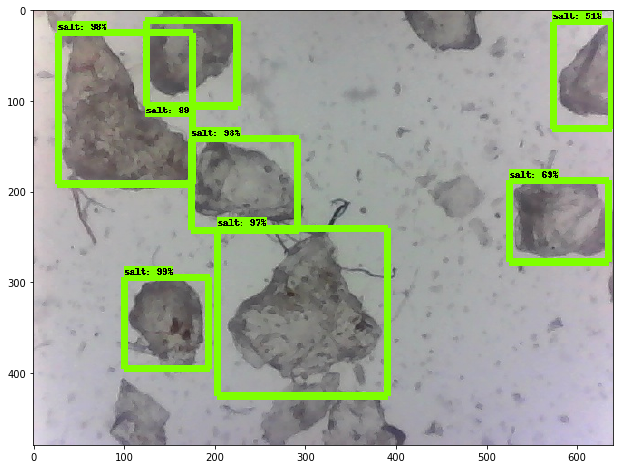

In [26]:
show(1589317363169)

In [ ]:
import tensorflow as tf
from tensorflow.python.platform import gfile
GRAPH_PB_PATH = '/opt/notebooks/DeepMicroscopy/training/frozen_inference_graph.pb'
with tf.Session() as sess:
   print("load graph")
   with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
       graph_def = tf.GraphDef()
   graph_def.ParseFromString(f.read())
   sess.graph.as_default()
   tf.import_graph_def(graph_def, name='')
   graph_nodes=[n for n in graph_def.node]
   names = []
   for t in graph_nodes:
      names.append(t.name)
   print(names)


In [28]:
input_names = ['image_tensor']
output_names = ['detection_boxes','detection_scores','detection_multiclass_scores','detection_classes','num_detections','raw_detection_boxes','raw_detection_scores']

In [29]:
import tensorflow.contrib.tensorrt as trt

trt_graph = trt.create_inference_graph(
    input_graph_def=graph_def,
    outputs=output_names,
    max_batch_size=1,
    max_workspace_size_bytes=1 << 25,
    precision_mode='FP16',
    minimum_segment_size=50
)

In [30]:
 with open('/opt/notebooks/DeepMicroscopy/training/trt_graph_8.pb', 'wb') as f:
    f.write(trt_graph.SerializeToString())